In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots,CSV,DataFrames;
import NLsolve,Roots;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [46]:
function pwa_central_deform(p, q, usq)::ComplexF64
    ξ = (p^2 + q^2 + usq) / (2 * p * q)
    tmp = zero(ComplexF64)
    if iszero(p) || iszero(q)
        tmp = 1 / (p^2 + q^2 + usq)
    else
        tmp = (abs(real(ξ))<1&&imag(ξ)<0) ? -1 / (4 * p * q) * (log(ξ - 1) - log(ξ + 1)+im*2π) : -1 / (4 * p * q) * (log(ξ - 1) - log(ξ + 1))
    end
    return tmp
end

pwa_central_deform (generic function with 1 method)

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [4]:
#https://github.com/fkguo/IMinuit.jl/blob/master/src/Data.jl
# check whether the data are valid for a fit
function check_data(xdata, ydata, errdata)
    if any(ismissing, xdata) || any(ismissing, ydata) || any(ismissing, errdata)
        error("Error: Data contain `missing` values.")
    end
    if any(isinf, xdata) || any(isinf, ydata) || any(isnan, xdata) || any(isnan, ydata) || any(isnan, errdata)
        error("Error: Data contain `Inf` or `NaN` values.")
    end
    if any(iszero, errdata)
        error("Error: Data contain 0 in the errors.")
    end
end

"""
    Data(x::T, y::T, err::T) where {T<:Vector{Real}}
    Data(df::DataFrame)
Fields: `x, y, err, ndata`
This defines a type for data with three columns:` x, y, err`; `ndata` is the number of data rows.
Different `Data` sets can be concatenated as `vcat(dat1, dat2, dat3)`.
Only symmetric errors (of `y`) are supported.
"""
struct Data
    x::Vector{Float64}
    y::Vector{Float64}
    err::Vector{Float64}
    ndata::Int
    function Data(x, y, err) # Data(x::Vector{T}, y::Vector{T}, err::Vector{T}) where {T<:Real}
        check_data(x, y, err)
        ndata = length(x)
        new(x, y, err, ndata)
    end
end

Data(df::DataFrame) = Data(df[:,1], df[:,2], df[:,3])

import Base.vcat, Base.getindex
vcat(dat1::Data, dat2::Data) = Data(vcat(dat1.x, dat2.x), vcat(dat1.y, dat2.y), vcat(dat1.err, dat2.err))
vcat(dat1::Data, dat...) = reduce(vcat, [dat1, dat...])
getindex(data::Data, in) = Data(map(x-> getindex(x, in), (data.x, data.y, data.err))...)

"""
    @plt_data(data, kws...)
    @plt_data!(data, kws...)
Convenient mascros to make an errorbar plot of the `data`; all combinations of
keyword settings for `scatter` in `Plots` can be used for the optional arguments `kws...`
"""
macro plt_data(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end
macro plt_data!(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter!($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter!($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end


@doc raw"""
    chisq(dist::Function, data, par; fitrange = ())
defines the ``\chi^2`` function: `fun` the function to be fitted to the data given by `data`.
The parameters are collected into `par`, given as an array or a tuple.
* `data` can be either given as the `Data` type, or of the form `(xdata, ydata [, err])`.
If no `err` is given explicitly, the errors are assumed to be 1 for all data points.
* `fitrange`: default to the whole data set; may given as, e.g., `2:10`,
which means only fitting to the 2nd to the 10th data points.
"""
function chisq(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
    end
    return res
end
# function chisq(dist::Function, data::Data, par::Tuple; fitrange = ())
#     fitrange = (isempty(fitrange) && 1:data.ndata)
#     res = 0.0
#     @simd for i = fitrange
#         @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
#     end
#     return res
# end
function chisq(dist::Function, data, par; fitrange = ())
    _x = data[1]; _y = data[2]
    _n = length(_x)
    _err = (length(data) == 2 ? ones(_n) : data[3])
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (_y[i]- dist(_x[i], par))/_err[i] )^2
    end
    return res
end

"""
    @plt_best(dist, fit, data, kws...)
    @plt_best!(dist, fit, data, kws...)
A convenient macro for comparing the best-fit result with the data; all combinations of
keyword settings for `plot` in `Plots` can be used for the optional arguments `kws...`
The ordering of `dist`, `fit`, and `data` does not matter.
"""
macro plt_best(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end
macro plt_best!(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter!($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

quadgauss (generic function with 1 method)

# VGT

In [5]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [6]:
xxx,www=gauss(40,0,1);
xxx3,www3=gauss(40*3,0,1);

qi=zeros(ComplexF64,2+4*length(xxx));
wi=zeros(ComplexF64,3*length(xxx));
len=length(xxx);
sublen=length(qi);

In [7]:
function Einner(E,q,m1,m2,m3,m12)
    return E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
end

function find_qint(E,m1,m2,m3,m12;rtol=1e-6)
    Etmp=E+m12-m1-m2-im*rtol
    qtmp=sqrt(λf(Etmp^2,m12^2,m3^2))/(2*Etmp)
    return imag(qtmp)>0 ? -qtmp : qtmp
end

function sol_qint3(qint1,qint2)
    a,b=reim(qint1)
    c,d=reim(qint2)
    return b*(c-a)/(b-d)+a
end

function find_qw(E,Λ=0.5;qi=qi,wi=wi,xxx=xxx,www=www,xxx3=xxx3,www3=www3)
    
    pmax=sqrt(abs(λf(E^2,mDn^2,(mπc+mDn)^2)))/(2*E)
    
    # wi is the one wrappered with g'(x)
    qi[1],qi[2]=qon_c(E),qon_0(E)
    
    for i in eachindex(xxx)
        qi[2+i]=pmax*xxx[i]
    end
    
    if imag(E)>=0||(real(E)<=mDn+mDn+mπc)
        for i in eachindex(xxx3)
            qi[i+len+2]=Λ*xxx3[i]
            wi[i]=Λ*www3[i]
        end
        return nothing
    end
    
    # find closet DDπ
    qint1,qint2=zeros(ComplexF64,2)
    if real(E)>mDc+mDc+mπc
        qint1=find_qint(E,mDc,mπc,mDc,mDsn)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    elseif real(E)>mDc+mDn+mπn
        qint1=find_qint(E,mDc,mπn,mDn,mDsc)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    else
        qint1=find_qint(E,mDn,mπc,mDn,mDsc)
        qint2=2*real(qint1)
    end
    
    @assert real(qint1)>0&&imag(qint1)<0 "Wrong qint1 position!"
    @assert imag(qint2)>imag(qint1)&&imag(qint2)<=0&&real(qint2)>real(qint1) "Wrong qint2 position!"
    
    qint3=sol_qint3(qint1,qint2)
    for i in eachindex(xxx)
        qi[2+len+i]=qint1*xxx[i]
        qi[2+2*len+i]=qint1+(qint3-qint1)*xxx[i]
        qi[2+3*len+i]=qint3 +(Λ-qint3) *xxx[i]
        wi[i]=qint1*www[i]
        wi[i+len]=(qint3-qint1)*www[i]
        wi[i+2*len]=(Λ-qint3)*www[i]
    end
    return nothing
end

find_qw (generic function with 2 methods)

In [70]:
sqrt(abs(λf(3.877^2,mDn^2,(mπc+mDn)^2)))/(2*3.877)

0.12242612247398255

In [8]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [9]:
function VMat!(E;Λ=0.5,a = 0.0,a1=0.0,I=0,plist=qi,des=Vmat)
    find_qw(E,Λ)
    k1,k2=plist[1],plist[2]

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [68]:
# @btime 
VMat!(mDn+mDsc-360e-6-im*24e-6)

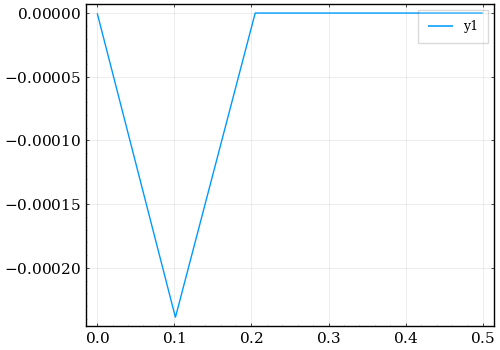

In [69]:
plot(real.(qi[3+len:end]),imag.(qi[3+len:end]))

In [59]:
# testval1=
Vmat

324×324 Matrix{ComplexF64}:
    1.03452-0.395247im     4.04032-0.0381415im   …  13.1896-0.000921879im
    4.04032-0.0381415im    4.49877-0.0230533im      13.5657+0.00272195im
   0.512868-0.267469im     4.02031-0.0301829im      13.1875+2.86916e-17im
   0.512238-0.267565im     4.02029-0.0301842im      13.1875+2.86919e-17im
    0.50896-0.268065im     4.02017-0.0301907im      13.1875+2.86934e-17im
    0.49941-0.269524im     4.01984-0.0302095im   …  13.1874+2.8698e-17im
   0.478431-0.272748im     4.01911-0.0302506im      13.1874+2.87081e-17im
    0.43934-0.278823im     4.01776-0.0303263im      13.1872+2.87266e-17im
   0.373823-0.289204im     4.01557-0.0304504im      13.1869+2.87572e-17im
   0.271632-0.305898im     4.01228-0.0306374im      13.1865+2.8804e-17im
   0.120017-0.331817im     4.00769-0.030901im    …   13.186+2.88712e-17im
 -0.0972228-0.371411im     4.00165-0.0312526im      13.1852+2.89633e-17im
  -0.401111-0.431824im     3.99413-0.0316988im      13.1842+2.90848e-17im
           ⋮ 

In [61]:
# testval2=
Vmat

324×324 Matrix{ComplexF64}:
    1.03452-0.395247im     4.04032-0.0381415im   …  13.1933-0.000922652im
    4.04032-0.0381415im    4.49877-0.0230533im      13.5695+0.00272281im
   0.512868-0.267469im     4.02031-0.0301829im      13.1911-2.87175e-17im
   0.512238-0.267565im     4.02029-0.0301842im      13.1911-2.87179e-17im
    0.50896-0.268065im     4.02017-0.0301907im      13.1911-2.87194e-17im
    0.49941-0.269524im     4.01984-0.0302095im   …  13.1911-2.8724e-17im
   0.478431-0.272748im     4.01911-0.0302506im       13.191-2.8734e-17im
    0.43934-0.278823im     4.01776-0.0303263im      13.1908-2.87526e-17im
   0.373823-0.289204im     4.01557-0.0304504im      13.1906-2.87833e-17im
   0.271632-0.305898im     4.01228-0.0306374im      13.1902-2.883e-17im
   0.120017-0.331817im     4.00769-0.030901im    …  13.1896-2.88973e-17im
 -0.0972228-0.371411im     4.00165-0.0312526im      13.1888-2.89895e-17im
  -0.401111-0.431824im     3.99413-0.0316988im      13.1878-2.91111e-17im
           ⋮   

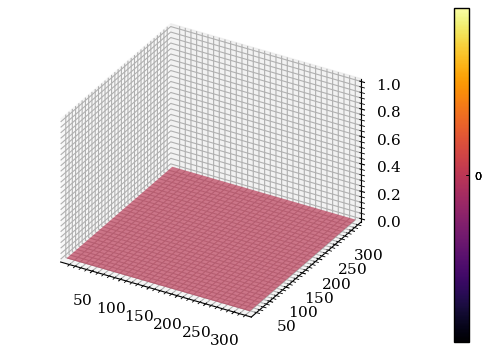

In [52]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(testval1[x,y]-testval2[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

In [53]:
testval1 .==testval2

324×324 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1 

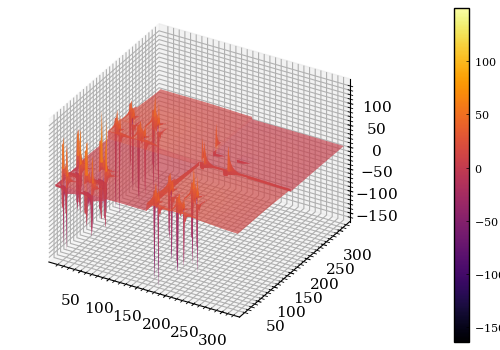

In [11]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

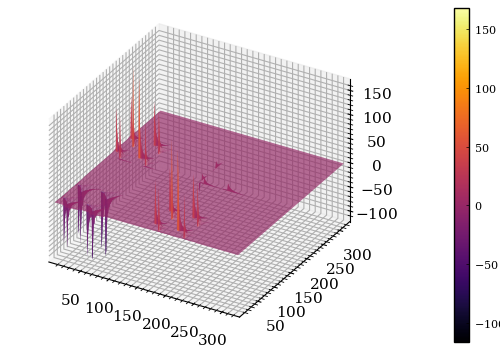

In [12]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

In [13]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [14]:
function GMat!(E;Λ=0.5,qi=qi,wi=wi,des=Gmat)
    find_qw(E,Λ)
    μ1,μ2=μf(mDn,mDsc),μf(mDc,mDsn)
    k1,k2=qi[1],qi[2]
    
    i=1
    for j in eachindex(wi)
        des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gc(E,qi[2+len+j])
    end
    
    i=2
    for j in eachindex(wi)
        des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gn(E,qi[2+len+j])
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [15]:
function detVG(E;Λ=0.5,a = 0.0,a1=0.0,I=0)
    VMat!(E;Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [16]:
function TMat!(E;Λ=0.5,a = 0.0,a1=0.0,I=0,des=Tmat)
    VMat!(E;Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [17]:
# @btime 
TMat!(3.875)

In [18]:
let 
    function inv_abst(x;E=mDn+mDsc-273e-6,I=0)
        TMat!(E;Λ=x[1],I=I,a1=1.0)
        return 1/abs(Tmat[1,1])
    end
    
    tmpf(x)=inv_abst(x)
    init_val=[0.5]
    lower=[0.3]
    upper=[1.2]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

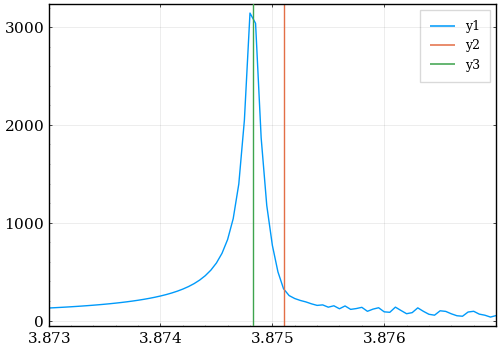

In [18]:
let Ev=collect(3.873:0.00005:3.877)
    function tmpf(E)
        TMat!(E;Λ=0.5987859640325228,a1=1.0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

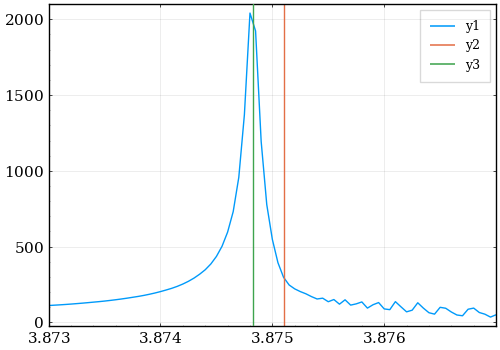

In [20]:
let Ev=collect(3.873:0.00005:3.877)
    function tmpf(E)
        TMat!(E;Λ=0.5987859640325228,a1=1.0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

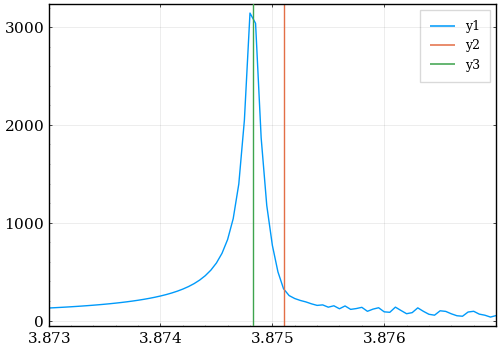

In [22]:
let Ev=collect(3.873:0.00005:3.877)
    function tmpf(E)
        TMat!(E;Λ=0.5987859640325228,a1=1.0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

In [63]:
mπc^2 -q0f(mDn+mDsc, mDn, mDsc, mDsc, mDn)^2

-0.0016670826352479656

In [67]:
mπc^2 - q0f(mDn+mDsc, mDc, mDsn, mDsn, mDc)^2

0.0006318533591980965

In [65]:
mπn^2 - q0f(mDn+mDsc, mDn, mDsc, mDsn, mDc)^2

-0.001762240181737474

# Observable

In [23]:
using Interpolations;

In [24]:
xxx1,www1=gauss(50,0,1);
function maketmatrixf(E)
    tmatrix=zeros(ComplexF64,len)
    tmp=zero(ComplexF64)
    for k in 3:(2+len)
        tmp=1.0
        for i in eachindex(wi)
            tmp+=wi[i]*qi[2+len+i]^2*Gc(E,qi[2+len+i])*Tmat[k,2+len+i]
            tmp+=-wi[i]*qi[2+len+i]^2*Gn(E,qi[2+len+i])*Tmat[k,sublen+2+len+i]
        end
        tmatrix[k-2]=tmp
    end
    return LinearInterpolation(real.(qi[3:2+len]),tmatrix)
end

maketmatrixf (generic function with 1 method)

In [25]:
function Γ3f(E;Λ = 0.5,a1=0.0)
     TMat!(E;Λ = Λ,a1=a1)

    res = 0.0
    μ1, μ2 = μf(mDn, mDsc), μf(mDc, mDsn)
    m1,m2,m3=mDn,mπc,mDn

    tmptmatrixf = maketmatrixf(E)
    tmatrixf(p) = (real(qi[3]) <= p && p <= real(qi[2+len])) ? tmptmatrixf(p) : 0.0
    for i in eachindex(xxx1)
        for j in eachindex(xxx1)
            x1, x2, w1, w2 = xxx1[i], xxx1[j], www1[i], www1[j]
            s23=(m2+m3)^2*(1-x1)+(E-m1)^2*x1
            s12_min=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)-sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12_max=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)+sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12=s12_min*(1-x2)+s12_max*x2
            q,qbar=sqrt(λf(s23,mπc^2,mDn^2))/(2*sqrt(s23)),sqrt(λf(s12,mDn^2,mπc^2))/(2*sqrt(s12))
            p,pbar=sqrt(λf(E^2,mDn^2,s23))/(2*E),sqrt(λf(E^2,mDn^2,s12))/(2*E)
            res+=w1*w2*abs((E-m1)^2-(m2+m3)^2)*abs(s12_max-s12_min)*abs(q*tmatrixf(p)*Gc(E,p)+qbar*tmatrixf(pbar)*Gc(E,pbar))^2
        end
    end
    return res
end

Γ3f (generic function with 1 method)

In [26]:
function Resolution(E, E1)
    σ1 = 1.05 * 263e-6
    σ2 = 2.413 * σ1
    α = 0.778
    gaussfunc(x, μ, σ) = 1 / sqrt(2 * π) / σ * exp(-(x - μ)^2 / (2 * σ^2))
    return α * gaussfunc(E, E1, σ1) + (1 - α) * gaussfunc(E, E1, σ2)
end

Resolution (generic function with 1 method)

# fitting

In [27]:
using PyCall;
import NLsolve;
piminuit=pyimport("iminuit");

In [28]:
let 
    data_ddπ_sub_df = DataFrame(CSV.File("./data/ddpi_sub_du.csv", header = ["x", "y"]));
    len=length(data_ddπ_sub_df.x)
    len1=Int64(len/3)
    xv=[3.8731+0.0002*(i-1) for i in 1:20]
    yv=[data_ddπ_sub_df.y[3*(i-1)+2] for i in 1:len1]
    wv=[abs(data_ddπ_sub_df.y[3*(i-1)+1]-data_ddπ_sub_df.y[3*(i-1)+3])/2 for i in 1:len1]
    global const data_ddπ_sub=Data(xv,yv,wv);
    nothing
end

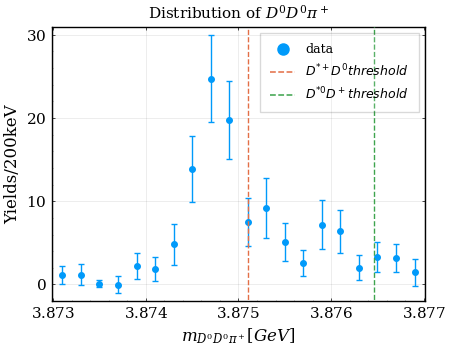

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.6056031611752245, 0.9786801175696073, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [29]:
@plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = "Yields/200keV" label = "data" size = (450, 350)
vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")

In [30]:
mutable struct distr
    Λ::Float64
    a1::Float64
    Γ3::Vector{Float64}
end

In [31]:
let Λ = 0.5987859640325228,a1=1.0,Ev = range(3.873, 3.877, 100)
    resv = [Γ3f(e; Λ = Λ,a1=a1) for e in Ev]
    global distr_inst = distr(Λ,a1, resv)
end

distr(0.5987859640325228, 1.0, [0.007292451068053033, 0.007930603358112638, 0.00863182461816066, 0.009403739447326885, 0.010252987082330323, 0.011189912669877365, 0.012225583331851694, 0.013373633503462759, 0.014647034334460622, 0.016064573597771047  …  0.7708346762049881, 0.5345799092609127, 1.1563667677732137, 3.8118497941409197, 3.5069647251164415, 1.6078451464463988, 1.0940854099954922, 0.6454924573402399, 0.37114451170570295, 1.25764983579479])

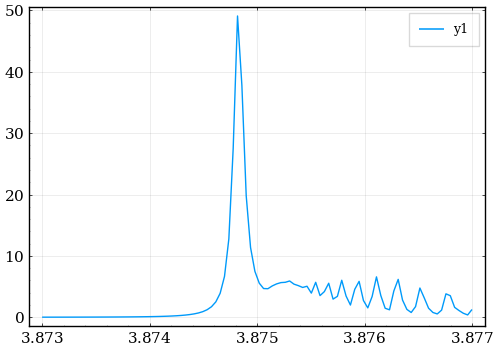

In [32]:
plot(range(3.873, 3.877, 100),distr_inst.Γ3)

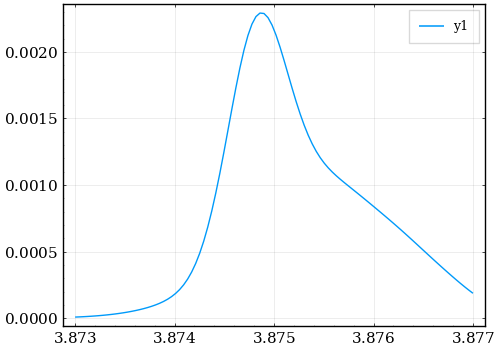

In [33]:
let
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, distr_inst.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xxx1, www1)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x 
    tmpf1(E)=quadgauss(x->ΔE*tmpf(Ebin(E,x)),xxx1,www1)
    plot(Ev,tmpf1.(Ev))
end

In [34]:
function remake_distr(dis::distr, Λ,a1)
    if Λ ≈ dis.Λ&&a1≈dis.a1
        return false
    else
        Ev = range(3.873, 3.877, 100)
        for i in eachindex(dis.Γ3)
            dis.Γ3[i] = Γ3f(Ev[i];Λ = Λ,a1=a1)
        end
        dis.Λ = Λ
        dis.a1=a1
    end
    return true
end

remake_distr (generic function with 1 method)

In [35]:
function dist(E, pars; dis = distr_inst, xx = xxx1, ww = www1)
    N, Λ,a1 = pars
    remake_distr(dis, Λ,a1)
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, dis.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xx, ww)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x
    return N * quadgauss(x->ΔE*tmpf(Ebin(E,x)),xx,ww)
end

dist (generic function with 1 method)

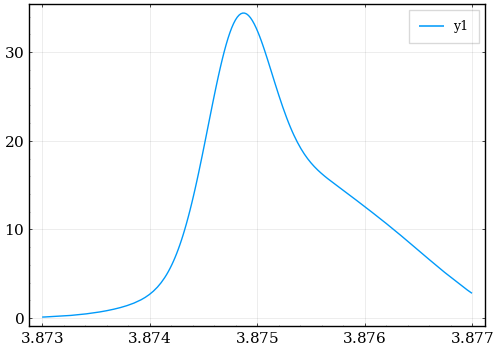

In [36]:
plot(e->dist(e,[1,0.5987859640325228,1.0])*30/0.002,3.873,3.877)

In [37]:
fcn(x,y,z; fitrange = ()) = chisq(dist, data_ddπ_sub,[x,y,z]; fitrange = fitrange)

fcn (generic function with 1 method)

In [38]:
function find_poles(pars)
    _lam,_a1=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,a1=_a1)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, 0.0])
end

find_poles (generic function with 1 method)

In [21]:
# function find_poles(pars)
#     _lam,_a1=pars
#     function f!(F, x)
#         e, γ = x
#         tmp = detVG(e + im * γ; Λ = _lam,a1=_a1)
#         F[1] = real(tmp)
#         F[2] = imag(tmp)
#     end
#     tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, 0.0])
#     (tmp.zero[1]-mDn-mDsc)+im*tmp.zero[2]
# end

find_poles (generic function with 1 method)

In [43]:
find_poles([0.6057714895276884,1.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, 0.0]
 * Zero: [3.874703735117374, 1.7334513657835778e-6]
 * Inf-norm of residuals: 0.007626
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 56
 * Jacobian Calls (df/dx): 5

In [44]:
3.874703735117374-mDn-mDsc

-0.0003962648826263404

## fitting result

In [48]:
let 
    _n,_lam,_a1=[11000,0.5987859640325228,1.0]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,a1=_a1,name=("N","lam","a1"))
    set!(tmp_model.limits,"N",(5000,15000))
    set!(tmp_model.limits,"lam",(0.3,1.2))
    set!(tmp_model.fixed,"a1",true)
    fitres=piminuit.Minuit.migrad(tmp_model) 
    print(fitres.values)
end

PyObject <ValueView N=7224.4170589484 lam=0.6057714895276884 a1=1.0>

In [50]:
fcn(7224.4170589484,0.6057714895276884,1.0)

15.407853730153741

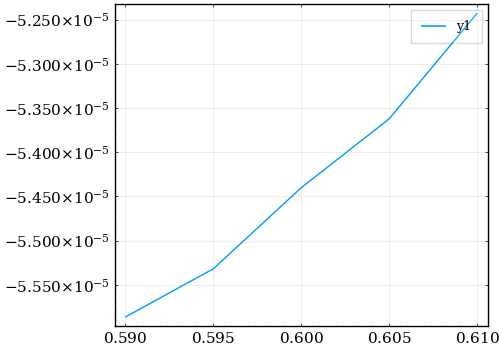

In [84]:
plot(0.59:0.005:0.61,x->imag.(find_poles([x,1.0])))

In [82]:
find_poles([0.6057714895276884,1.0])

-0.00040200764915754306 - 5.347549439056407e-5im

In [53]:
3.8746978549480144-mDn-mDsc

-0.00040214505198576944

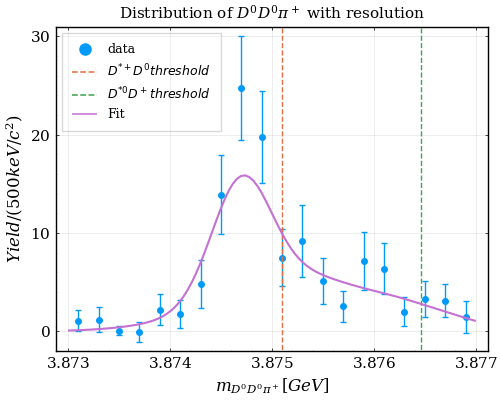

In [51]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [7224.4170589484,0.6057714895276884,1.0]), lw = 1.5, label = "Fit")
end

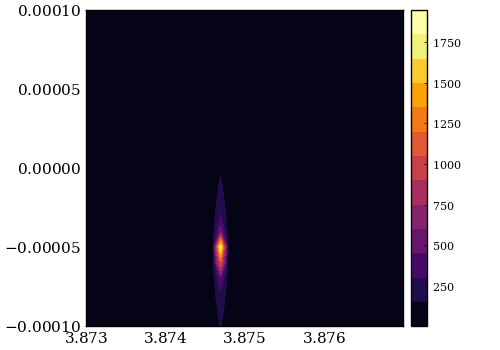

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [55]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.6057714895276884,a1=1.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

In [56]:
let 
    _n,_lam,_a1=[5000,0.5,0.5]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,a1=_a1,name=("N","lam","a1"))
    set!(tmp_model.limits,"N",(1000,10000))
    set!(tmp_model.limits,"lam",(0.3,0.9))
    set!(tmp_model.limits,"a1",(0.0,1.0))
    fitres=piminuit.Minuit.migrad(tmp_model) 
    print(fitres.values)
end

PyObject <ValueView N=7120.306892274345 lam=0.6096618681795485 a1=0.9897638425454487>

In [57]:
fcn(7120.306892274345,0.6096618681795485,0.9897638425454487)

15.381710078370478

In [70]:
find_poles([0.6096618681795485,0.9897638425454487])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, 0.0]
 * Zero: [3.874697834177173, -5.3460686027638403e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [59]:
3.874697690801883-mDn-mDsc

-0.0004023091981171234

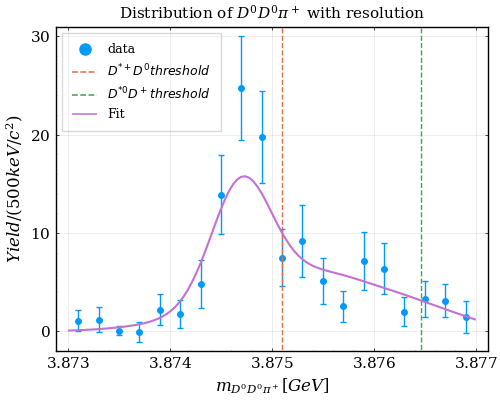

In [69]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [7120.306892274345,0.6096618681795485,0.9897638425454487]), lw = 1.5, label = "Fit")
end

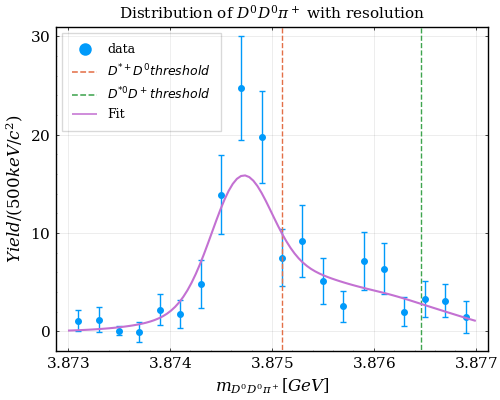

In [60]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [7120.306892274345,0.6096618681795485,0.9897638425454487]), lw = 1.5, label = "Fit")
end

In [77]:
find_poles([0.4,1.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, 0.0]
 * Zero: [3.8767655299618524, -5.236669564487874e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 39
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 28
 * Jacobian Calls (df/dx): 18

In [78]:
3.8767655299618524-mDn-mDsc

0.001665529961852208

### real pion fit

In [43]:
# ----------------------------------------------------------DD*----------------------------------------------------#
function potential_DnDsc(E, p, q; I=0, a=0.0, a1=0.0, isπ=true)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    # res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2)
    # res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2)
    if isπ == true
        res += real(-4 * g^2 / fπ^2 / sqrt(16) * pwa_tensor_ss_deform(p, q, mπc^2 - q02^2; a=a1) * (I - 1 / 2) * 2)
    end
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * pwa_tensor_ss(p, q, mρc^2 - q02^2; a=a) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2) * (-2)
    return res
end

function potential_DcDsn(E, p, q; I=0, a=0.0, a1=0.0, isπ=true)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)

    # res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2)
    # res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2)
    if isπ == true
        res += real(-4 * g^2 / fπ^2 / sqrt(16) * pwa_tensor_ss_deform(p, q, mπc^2 - q02^2; a=a1) * (I - 1 / 2) * 2)
    end
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * pwa_tensor_ss(p, q, mρc^2 - q02^2; a=a) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2) * (-2)
    return res
end

function potential_DDscross(E, p, q; I=0, a=0.0, a1=0.0, isπ=true)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2)
    if isπ == true
        res += real(2 * g^2 / fπ^2 / sqrt(16) * pwa_tensor_ss_deform(p, q, mπn^2 - q02^2; a=a1) * (I - 1 / 2) * 2)
    end
    res += -2 * g^2 / (3fπ^2) / sqrt(16) * pwa_tensor_ss(p, q, mη^2 - q02^2; a=a) * (I - 1 / 2) * 2
    # res += (-(2 * gV * gλ)^2 / sqrt(16) * pwa_tensor_ss(p, q, mρn^2 - q02^2; a=a) * (I - 1 / 2) * 2)
    # res += ((2 * gV * gλ)^2 / sqrt(16) * pwa_tensor_ss(p, q, mω^2 - q02^2; a=a) * (I - 1 / 2) * 2)
    #ηc,J/ψ
    res += 2 * g^2 / fπ^2 / sqrt(16) * pwa_tensor_ss(p, q, mηc^2 - q02^2; a=a) * (-2) * (I - 1 / 2) * 2
    res += (-(2 * gV * gλ)^2 / sqrt(16) * pwa_tensor_ss(p, q, mJψ^2 - q02^2; a=a) * (I - 1 / 2) * 2 * (-2))
    return res
end

potential_DDscross (generic function with 1 method)

In [48]:
let 
    _n,_lam,_a1=[11000,0.5987859640325228,1.0]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,a1=_a1,name=("N","lam","a1"))
    set!(tmp_model.limits,"N",(5000,15000))
    set!(tmp_model.limits,"lam",(0.3,1.2))
    set!(tmp_model.fixed,"a1",true)
    fitres=piminuit.Minuit.migrad(tmp_model) 
    print(fitres.values)
end

PyObject <ValueView N=5000.002087304424 lam=0.5969768232606261 a1=1.0>

# Combine serveral fit

In [33]:
fit_df1=DataFrame(CSV.File("./output/fit1.csv", header = ["x", "y"]));
fit_df2=DataFrame(CSV.File("./output/fit2.csv", header = ["x", "y"]));

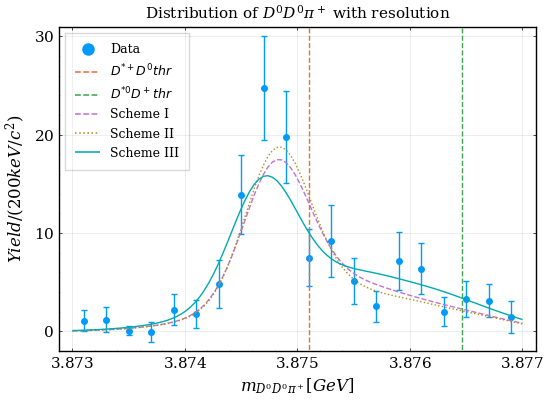

In [42]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(200keV/c^2)" label = "Data" size = (550, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 thr")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ thr")
    plot!(Ev,fit_df1.y,ls=:dash,label="Scheme I")
    plot!(Ev,fit_df2.y,ls=:dot,label="Scheme II")
    plot!(Ev, e -> dist(e, [7224.4170589484,0.6057714895276884,1.0]), label = "Scheme III")
end

# Test